In [99]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss
from numpy.linalg import inv
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [100]:
path = "data/decisions_2016_2024.csv"
df = pd.read_csv(path)

In [101]:
df.columns

Index(['season', 'week', 'game_id', 'game_date', 'play_id', 'posteam',
       'defteam', 'home_team', 'away_team', 'posteam_type', 'qtr',
       'game_seconds_remaining', 'half_seconds_remaining',
       'quarter_seconds_remaining', 'down', 'ydstogo', 'yardline_100',
       'score_differential', 'home_timeouts_remaining',
       'away_timeouts_remaining', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining', 'roof', 'surface', 'temp', 'wind',
       'play_type', 'punt_attempt', 'field_goal_attempt', 'rush_attempt',
       'pass_attempt', 'epa', 'wpa', 'success', 'yards_gained', 'first_down',
       'touchdown', 'field_goal_result', 'kick_distance', 'punt_inside_twenty',
       'punt_out_of_bounds', 'punt_downed', 'punt_fair_catch', 'return_yards',
       'penalty', 'aborted_play', 'play_deleted', 'goal_to_go', 'timeout',
       'timeout_team', 'off_epa_4w', 'def_epa_4w', 'plays_in_drive_so_far',
       'play_elapsed_s', 'game_time_elapsed', 'def_time_on_field_cum',
       

In [102]:
actions = ["go", "punt", "fg"]
reward = "wpa"

In [103]:
df = df[df["action"].isin(actions)].copy()

In [104]:
df = df[~df[reward].isna()].copy()

In [105]:
numeric_candidates = [
    # core context
    'yardline_100','ydstogo','score_differential','qtr','game_seconds_remaining',

    # team strength (rolling averages)
    'off_epa_4w','def_epa_4w',

    # special teams
    'fg_pct_short','fg_pct_mid','fg_pct_long','punt_net_4w',

    # fatigue / drive
    'plays_in_drive_so_far','def_time_on_field_cum','def_time_on_field_share',

    # NEW: timeouts
    'home_timeouts_remaining','away_timeouts_remaining',
    'posteam_timeouts_remaining','defteam_timeouts_remaining',

    # NEW: weather
    'temp','wind',

    # NEW: situational
    'goal_to_go'
]


In [106]:
present_numeric = [c for c in numeric_candidates if c in df.columns]

present_numeric

['yardline_100',
 'ydstogo',
 'score_differential',
 'qtr',
 'game_seconds_remaining',
 'off_epa_4w',
 'def_epa_4w',
 'fg_pct_short',
 'fg_pct_mid',
 'fg_pct_long',
 'punt_net_4w',
 'plays_in_drive_so_far',
 'def_time_on_field_cum',
 'def_time_on_field_share',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'temp',
 'wind',
 'goal_to_go']

In [107]:
cat_candidates = []
for c in ['posteam','defteam','home_team','away_team',
    'roof','surface']:
    if c in df.columns:
        cat_candidates.append(c)

cat_candidates


['posteam', 'defteam', 'home_team', 'away_team', 'roof', 'surface']

In [108]:
from sklearn.impute import SimpleImputer

feature_cols = present_numeric + cat_candidates
X_raw = df[feature_cols].copy()
y_action = df['action'].copy()
r = df[reward].astype(float).to_numpy()

X_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

mask = y_action.notna()
X_fit = X_raw.loc[mask]
y_fit = y_action.loc[mask]

num_tf = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

if len(cat_candidates):
    cat_tf = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    )
    pre = ColumnTransformer(
        transformers=[
            ("num", num_tf, present_numeric),
            ("cat", cat_tf, cat_candidates),
        ]
    )
else:
    pre = ColumnTransformer(
        transformers=[("num", num_tf, present_numeric)]
    )

In [109]:
missing = X_fit.isna().sum()
print("Missing (pre-impute view):")
print(missing[missing > 0])

Missing (pre-impute view):
temp       11046
wind       11046
surface      577
dtype: int64


In [110]:
beh_model = make_pipeline(
    pre,
    LogisticRegression(multi_class="multinomial", max_iter=2000, C=1.0, solver="lbfgs")
)
beh_model.fit(X_fit, y_fit)

classes = list(beh_model.named_steps['logisticregression'].classes_)
P_b = beh_model.predict_proba(X_fit)
class_to_idx = {c: i for i, c in enumerate(classes)}

a_idx = y_fit.map(class_to_idx).to_numpy()

p_b_logged = P_b[np.arange(len(X_fit)), a_idx]

mean_probs = P_b.mean(axis=0)
pred_actions = P_b.argmax(axis=1)
acc = (pred_actions == a_idx).mean()

print("Classes:", classes)
print("Mean action probs:", dict(zip(classes, np.round(mean_probs, 3))))
print("In-sample acc:", round(acc, 3))
print("p_b_logged: min/mean/max",
      np.min(p_b_logged), np.mean(p_b_logged), np.max(p_b_logged))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classes: ['fg', 'go', 'punt']
Mean action probs: {'fg': 0.263, 'go': 0.178, 'punt': 0.558}
In-sample acc: 0.856
p_b_logged: min/mean/max 5.130196364207763e-06 0.785620064352437 0.9999997092393565


In [111]:
mask_fit = y_fit.notna() if 'mask_fit' not in locals() else mask_fit  # keep if you already defined it
X_use = X_fit  # already filtered above when you trained beh_model
y_use = y_fit
r_use = r[mask_fit.to_numpy()]  # align rewards to the same rows

In [112]:
pre = beh_model.named_steps['columntransformer']
X_design = pre.transform(X_use)

In [113]:
arm_models = {}
l2 = 5.0

for a in classes:
    arm_mask = (y_use == a).to_numpy()
    X_arm = X_design[arm_mask]
    y_arm = r_use[arm_mask]

    if X_arm.shape[0] < 50:
        mu = float(np.mean(y_arm)) if y_arm.size else 0.0
        model = ("const", mu)
    else:
        model = Ridge(alpha=l2, fit_intercept=True)
        model.fit(X_arm, y_arm)
    arm_models[a] = model

In [114]:
def predict_mu_all(Xd):
    N, K = Xd.shape[0], len(classes)
    MU = np.zeros((N, K), dtype=float)
    for j, a in enumerate(classes):
        m = arm_models[a]
        if isinstance(m, tuple) and m[0] == "const":
            MU[:, j] = m[1]
        else:
            MU[:, j] = m.predict(Xd)
    return MU

MU = predict_mu_all(X_design)  # shape (N_fit, K)
N_fit = MU.shape[0]

In [115]:
from scipy import sparse

# (1) Greedy DM
a_star_DM_idx = MU.argmax(axis=1)

# (2) LinUCB (one-shot / pre-game)
alpha = 0.8
lambda_ucb = 5.0
d = X_design.shape[1]
scores_ucb = np.zeros_like(MU)

V_inv = {}
theta = {}
intercepts = {}

for a in classes:
    arm_mask = (y_use == a).to_numpy()
    X_a = X_design[arm_mask]
    y_a = r_use[arm_mask]

    # Intercept & theta from the fitted arm model (or zeros for constant model)
    m = arm_models[a]
    if isinstance(m, tuple) and m[0] == "const":
        intercepts[a] = m[1]
        theta[a] = np.zeros(d)
    else:
        intercepts[a] = float(m.intercept_)
        theta[a] = m.coef_.reshape(-1)

    # Precision (X^T X + λI)^(-1); fallback if too few samples
    if X_a.shape[0] < d + 1:
        V_inv[a] = np.eye(d) / lambda_ucb
    else:
        XtX = X_a.T @ X_a
        V = XtX + lambda_ucb * np.eye(d)
        V_inv[a] = inv(V)  # or: V_inv[a] = np.linalg.inv(V)

# Compute UCB scores
for j, a in enumerate(classes):
    th = theta[a]
    b0 = intercepts[a]
    mu = X_design @ th + b0
    X = X_design

    if sparse.issparse(X):
        # (N,d) @ (d,d) -> (N,d), elementwise multiply with X, sum rows
        XV = X @ V_inv[a]                    # (N,d) sparse
        quad = np.array(X.multiply(XV).sum(axis=1)).ravel()  # (N,)
    else:
        # dense path
        X = np.asarray(X)
        XV = X @ V_inv[a]                    # (N,d)
        quad = np.sum(X * XV, axis=1)        # (N,)

    bonus = alpha * np.sqrt(np.maximum(quad, 0.0))
    scores_ucb[:, j] = mu + bonus

a_star_UCB_idx = scores_ucb.argmax(axis=1)

In [116]:
# ----- Doubly Robust OPE (deterministic target policy) -----
# (All arrays are length N_fit; use those!)
p_b_logged_fit = p_b_logged  # already computed on X_fit
a_idx_fit = a_idx            # already computed on y_fit
r_fit = r_use

def dr_ope(a_star_idx):
    N = N_fit  # consistent with MU.shape[0]
    w_ips_num = (a_idx_fit == a_star_idx).astype(float)
    w_ips = w_ips_num / np.clip(p_b_logged_fit, 1e-6, 1.0)

    mu_logged = MU[np.arange(N), a_idx_fit]
    mu_target = MU[np.arange(N), a_star_idx]

    dr = np.mean(w_ips * (r_fit - mu_logged) + mu_target)
    ips = np.mean(w_ips * r_fit)

    w_match = w_ips[w_ips_num == 1.0]
    ess = (w_match.sum()**2 / np.sum(w_match**2)) if w_match.size else 0.0
    return float(dr), float(ips), float(ess)

dr_DM, ips_DM, ess_DM = dr_ope(a_star_DM_idx)
dr_UCB, ips_UCB, ess_UCB = dr_ope(a_star_UCB_idx)

In [117]:
def dr_ope_stochastic(P_eval):
    """
    Doubly-robust OPE for a *stochastic* target policy.
    P_eval: (N_fit, K) matrix, row i sums to 1, columns align with `classes`.
    Uses p_b_logged_fit, a_idx_fit, r_fit, MU (all length N_fit).
    """
    # Logged action prob under eval policy and behavior policy
    pi_e_logged = P_eval[np.arange(N_fit), a_idx_fit]              # (N,)
    w = pi_e_logged / np.clip(p_b_logged_fit, 1e-6, 1.0)           # importance ratio

    mu_logged = MU[np.arange(N_fit), a_idx_fit]                    # (N,)
    mu_target = np.sum(P_eval * MU, axis=1)                        # E_{a~π_e}[μ̂(x,a)]

    dr = np.mean(w * (r_fit - mu_logged) + mu_target)
    ips = np.mean(w * r_fit)
    # Optional: ESS on rows where pi_e_logged>0
    w_pos = w[pi_e_logged > 0]
    ess = (w_pos.sum()**2) / (np.sum(w_pos**2) + 1e-12) if w_pos.size else 0.0
    return float(dr), float(ips), float(ess)


In [118]:
# ----- Bootstrap CIs (resample rows in the *fit* set) -----
rng = np.random.default_rng(123)
B = 100

def bootstrap_dr(a_star_idx):
    vals = []
    for _ in range(B):
        idx = rng.integers(0, N_fit, size=N_fit)
        w_num_b = (a_idx_fit[idx] == a_star_idx[idx]).astype(float)
        w_b = w_num_b / np.clip(p_b_logged_fit[idx], 1e-6, 1.0)
        mu_logged_b = MU[idx, a_idx_fit[idx]]
        mu_target_b = MU[idx, a_star_idx[idx]]
        dr_b = np.mean(w_b * (r_fit[idx] - mu_logged_b) + mu_target_b)
        vals.append(dr_b)
    return np.percentile(vals, [2.5, 97.5])

ci_DM = bootstrap_dr(a_star_DM_idx)
ci_UCB = bootstrap_dr(a_star_UCB_idx)

In [119]:
summary = pd.DataFrame({
    "policy": ["Greedy-DM (argmax mu)", "LinUCB (pre-game)"],
    "estimate_DR_WPA": [dr_DM, dr_UCB],
    "DR_95%_CI_low": [ci_DM[0], ci_UCB[0]],
    "DR_95%_CI_high": [ci_DM[1], ci_UCB[1]],
    "IPS_only_WPA": [ips_DM, ips_UCB],
    "IPS_ESS": [ess_DM, ess_UCB],
})

diag_df = pd.DataFrame({
    "metric": (["N_rows_used", "behavior_pred_accuracy", "mean_logged_reward"]
               + [f"p_b_mean_{c}" for c in classes]),
    "value": ([N_fit, float(acc), float(np.mean(r_fit))]
              + [float(p) for p in mean_probs]),
})


In [120]:
summary

,policy,estimate_DR_WPA,DR_95%_CI_low,DR_95%_CI_high,IPS_only_WPA,IPS_ESS
0,Greedy-DM (argmax mu),0.018955,0.010958,0.026505,0.012219,338.848078
1,LinUCB (pre-game),0.062441,0.010261,0.156012,0.062551,44.386264


In [121]:
diag_df

,metric,value
0,N_rows_used,31849.000000
1,behavior_pred_accuracy,0.855882
2,mean_logged_reward,0.003046
3,p_b_mean_fg,0.263372
4,p_b_mean_go,0.178257
5,p_b_mean_punt,0.558371


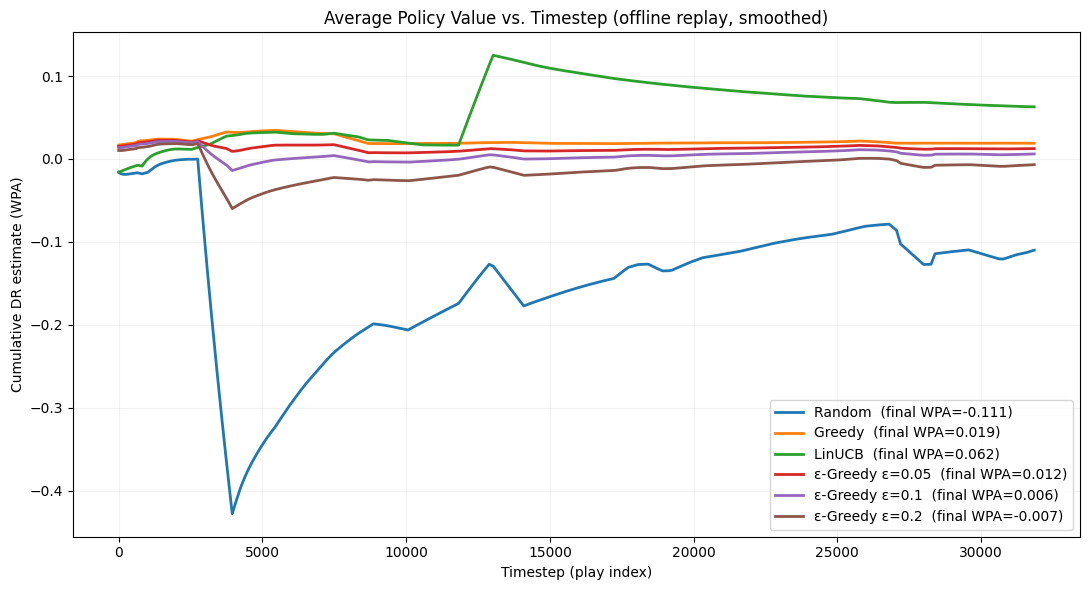

In [122]:
import matplotlib.pyplot as plt
# ------------------- DR building blocks -------------------
def dr_per_row_det(a_star_idx, MU, r, a_log, p_b):
    N = len(r)
    w_num = (a_log == a_star_idx).astype(float)
    w = w_num / np.clip(p_b, 1e-6, 1.0)
    mu_log = MU[np.arange(N), a_log]
    mu_tgt = MU[np.arange(N), a_star_idx]
    return w * (r - mu_log) + mu_tgt

def dr_per_row_sto(Pi_e, MU, r, a_log, p_b):
    N = len(r)
    pi_e_logged = Pi_e[np.arange(N), a_log]
    w = pi_e_logged / np.clip(p_b, 1e-6, 1.0)
    mu_log = MU[np.arange(N), a_log]
    mu_tgt = np.sum(Pi_e * MU, axis=1)
    return w * (r - mu_log) + mu_tgt

def pi_random(N, K):
    return np.full((N, K), 1.0 / K, dtype=float)

def pi_epsgreedy(MU, epsilon=0.1):
    N, K = MU.shape
    Pi = np.full((N, K), epsilon / K, dtype=float)
    g = MU.argmax(axis=1)
    Pi[np.arange(N), g] += (1.0 - epsilon)
    return Pi

def cummean(x):
    return np.cumsum(x) / np.arange(1, len(x) + 1)

def smooth(y, win=501):
    """Centered rolling mean; falls back if series shorter than window."""
    win = min(win, max(3, (len(y)//20)*2+1))  # odd window; ~5% of series if long
    return pd.Series(y).rolling(win, center=True, min_periods=1).mean().to_numpy()

# ------------------- Build and plot curves -------------------
def plot_policy_learning_curves(
    MU, r_fit, a_idx_fit, p_b_logged_fit, a_star_DM_idx, a_star_UCB_idx,
    ylabel="WPA", shuffle=True, seed=0, smooth_win=501, show_random=True
):
    rng = np.random.default_rng(seed)
    N, K = MU.shape
    order = rng.permutation(N) if shuffle else np.arange(N)

    psi_greedy = dr_per_row_det(a_star_DM_idx, MU, r_fit, a_idx_fit, p_b_logged_fit)[order]
    psi_ucb    = dr_per_row_det(a_star_UCB_idx, MU, r_fit, a_idx_fit, p_b_logged_fit)[order]

    curves = {}
    if show_random:
        psi_rand = dr_per_row_sto(pi_random(N, K), MU, r_fit, a_idx_fit, p_b_logged_fit)[order]
        curves["Random"] = cummean(psi_rand)

    curves["Greedy"] = cummean(psi_greedy)
    curves["LinUCB"] = cummean(psi_ucb)

    for eps in [0.05, 0.10, 0.20]:
        Pi = pi_epsgreedy(MU, epsilon=eps)
        psi_eps = dr_per_row_sto(Pi, MU, r_fit, a_idx_fit, p_b_logged_fit)[order]
        curves[f"ε-Greedy ε={eps:g}"] = cummean(psi_eps)

    # Smooth & collect terminal values
    curves_s = {k: smooth(v, win=smooth_win) for k, v in curves.items()}
    finals = {k: float(v[-1]) for k, v in curves.items()}

    plt.figure(figsize=(11,6))
    for name, y in curves_s.items():
        lab = f"{name}  (final {ylabel}={finals[name]:.3f})"
        plt.plot(y, label=lab, linewidth=2)

    plt.xlabel("Timestep (play index)")
    plt.ylabel(f"Cumulative DR estimate ({ylabel})")
    plt.title(f"Average Policy Value vs. Timestep (offline replay, smoothed)")
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.15)
    plt.tight_layout()
    plt.show()

    return finals


finals_wpa = plot_policy_learning_curves(MU, r_fit, a_idx_fit, p_b_logged_fit,
                                         a_star_DM_idx, a_star_UCB_idx,
                                         ylabel="WPA", shuffle=True, seed=7, smooth_win=1201)



In [123]:
dr_eq, ips_eq, ess_eq = dr_ope_stochastic(P_b)   # P_b from your fitted behavior model
print("DR(π_e = π_b) =", dr_eq, "  mean_logged_reward =", r_fit.mean())


DR(π_e = π_b) = 0.0030489218490367567   mean_logged_reward = 0.0030457610692848657


In [124]:
wpa_by_action = (
    df.groupby("action")["wpa"]
      .agg(["count", "mean", "std", "min", "max"])
      .reset_index()
)

print(wpa_by_action)

# Optional: sort by mean wpa to see which action looks best on average
wpa_by_action.sort_values("mean", ascending=False)

  action  count      mean       std       min       max
0     fg   8388  0.000841  0.062224 -0.683856  0.570333
1     go   5678  0.007348  0.088628 -0.752197  0.862577
2   punt  17783  0.002712  0.045451 -0.418035  0.944656


,action,count,mean,std,min,max
1,go,5678,0.007348,0.088628,-0.752197,0.862577
2,punt,17783,0.002712,0.045451,-0.418035,0.944656
0,fg,8388,0.000841,0.062224,-0.683856,0.570333


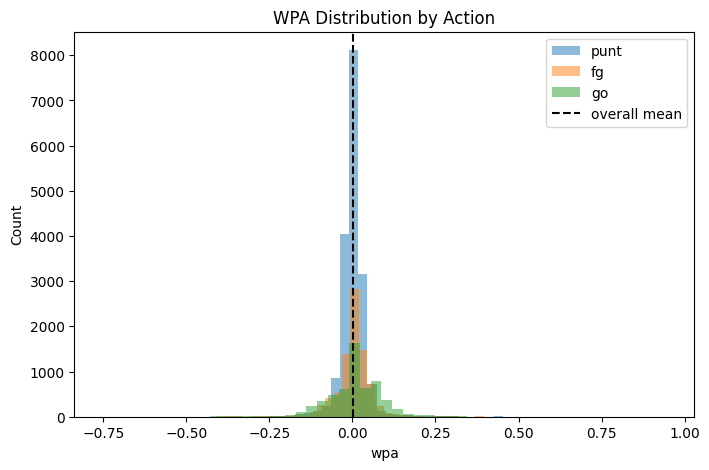

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for a in df["action"].unique():
    subset = df.loc[df["action"] == a, "wpa"]
    plt.hist(subset, bins=50, alpha=0.5, label=a)
plt.axvline(df["wpa"].mean(), color="k", linestyle="--", label="overall mean")
plt.xlabel("wpa")
plt.ylabel("Count")
plt.title("WPA Distribution by Action")
plt.legend()
plt.show()


In [126]:
# Bin yardline into field zones (e.g. red zone, midfield, own territory)
df['yardline_bin'] = pd.cut(
    df['yardline_100'],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["Red Zone (0-20)", "Opp 20-40", "Midfield (40-60)", "Own 40-20", "Own 20+"]
)

wpa_by_yardline = (
    df.groupby(['yardline_bin', 'action'])['wpa']
      .agg(['count', 'mean'])
      .reset_index()
      .sort_values(['yardline_bin','action'])
)

print(wpa_by_yardline)


        yardline_bin action  count      mean
0    Red Zone (0-20)     fg   4241 -0.003972
1    Red Zone (0-20)     go   1417 -0.003196
2    Red Zone (0-20)   punt      0       NaN
3          Opp 20-40     fg   4098  0.005833
4          Opp 20-40     go   1759  0.008645
5          Opp 20-40   punt    538 -0.015667
6   Midfield (40-60)     fg     49 -0.000011
7   Midfield (40-60)     go   1600  0.016161
8   Midfield (40-60)   punt   6035  0.001484
9          Own 40-20     fg      0       NaN
10         Own 40-20     go    789  0.006045
11         Own 40-20   punt   8644  0.004754
12           Own 20+     fg      0       NaN
13           Own 20+     go    113  0.003696
14           Own 20+   punt   2566  0.002573


In [127]:
df['ydstogo_bin'] = pd.cut(
    df['ydstogo'],
    bins=[0, 2, 5, 10, 20, 100],
    labels=["1-2", "3-5", "6-10", "11-20", "20+"]
)

wpa_by_ydstogo = (
    df.groupby(['ydstogo_bin','action'])['wpa']
      .agg(['count','mean'])
      .reset_index()
      .sort_values(['ydstogo_bin','action'])
)

print(wpa_by_ydstogo)


   ydstogo_bin action  count      mean
0          1-2     fg    961 -0.013769
1          1-2     go   3038  0.013026
2          1-2   punt   2113 -0.008619
3          3-5     fg   2376 -0.003471
4          3-5     go   1253  0.006922
5          3-5   punt   3676 -0.000953
6         6-10     fg   3270  0.002003
7         6-10     go    920 -0.004480
8         6-10   punt   6299  0.002645
9        11-20     fg   1634  0.012868
10       11-20     go    402 -0.002555
11       11-20   punt   4872  0.009547
12         20+     fg    147  0.006524
13         20+     go     65 -0.021147
14         20+   punt    823  0.008227


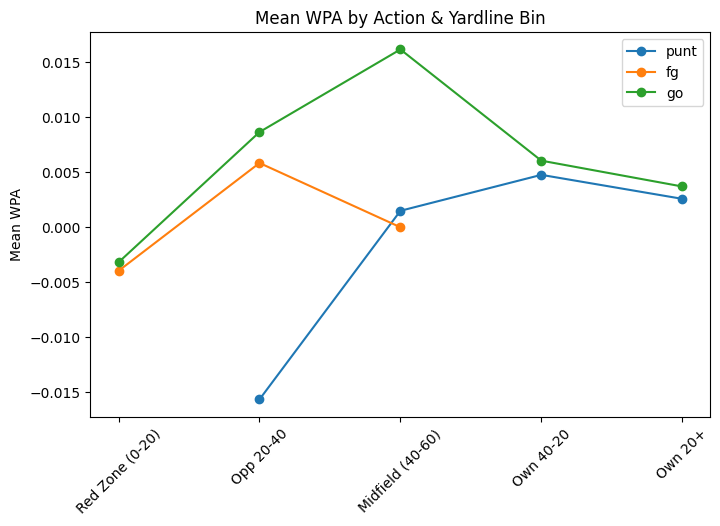

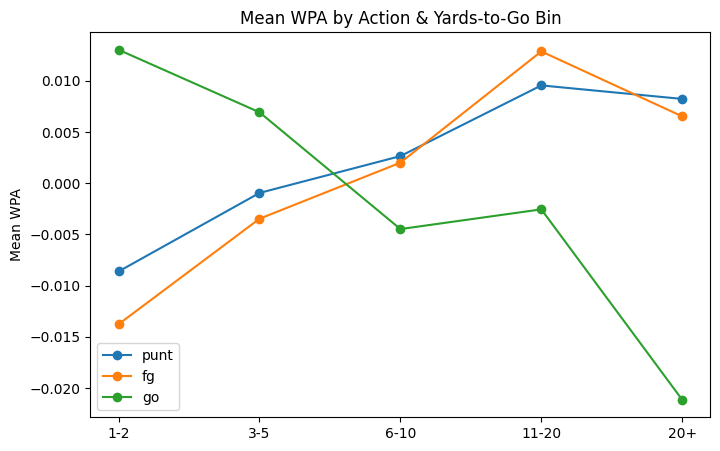

In [128]:
# Yardline plot
plt.figure(figsize=(8,5))
for a in df['action'].unique():
    subset = df.groupby('yardline_bin')['epa'].mean().reset_index()
    plt.plot(
        wpa_by_yardline.loc[wpa_by_yardline['action']==a,'yardline_bin'],
        wpa_by_yardline.loc[wpa_by_yardline['action']==a,'mean'],
        marker='o', label=a
    )
plt.xticks(rotation=45)
plt.ylabel("Mean WPA")
plt.title("Mean WPA by Action & Yardline Bin")
plt.legend()
plt.show()

# Yards-to-go plot
plt.figure(figsize=(8,5))
for a in df['action'].unique():
    plt.plot(
        wpa_by_ydstogo.loc[wpa_by_ydstogo['action']==a,'ydstogo_bin'],
        wpa_by_ydstogo.loc[wpa_by_ydstogo['action']==a,'mean'],
        marker='o', label=a
    )
plt.ylabel("Mean WPA")
plt.title("Mean WPA by Action & Yards-to-Go Bin")
plt.legend()
plt.show()


In [129]:
# Group mean WPA by yardline bin & action
wpa_by_yardline = (
    df.groupby(['yardline_bin','action'])['wpa']
      .mean().unstack()
)

# Compute ΔWPA of go vs best alternative
wpa_by_yardline['best_alt'] = wpa_by_yardline[['fg','punt']].max(axis=1)
wpa_by_yardline['delta_go'] = wpa_by_yardline['go'] - wpa_by_yardline['best_alt']

print("Decision table by yardline:")
print(wpa_by_yardline[['fg','punt','go','best_alt','delta_go']])


Decision table by yardline:
action                  fg      punt        go  best_alt  delta_go
yardline_bin                                                      
Red Zone (0-20)  -0.003972       NaN -0.003196 -0.003972  0.000776
Opp 20-40         0.005833 -0.015667  0.008645  0.005833  0.002813
Midfield (40-60) -0.000011  0.001484  0.016161  0.001484  0.014676
Own 40-20              NaN  0.004754  0.006045  0.004754  0.001291
Own 20+                NaN  0.002573  0.003696  0.002573  0.001123


In [130]:
wpa_by_ydstogo = (
    df.groupby(['ydstogo_bin','action'])['epa']
      .mean().unstack()
)

wpa_by_ydstogo['best_alt'] = wpa_by_ydstogo[['fg','punt']].max(axis=1)
wpa_by_ydstogo['delta_go'] = wpa_by_ydstogo['go'] - wpa_by_ydstogo['best_alt']

print("Decision table by ydstogo:")
print(wpa_by_ydstogo[['fg','punt','go','best_alt','delta_go']])


Decision table by ydstogo:
action             fg      punt        go  best_alt  delta_go
ydstogo_bin                                                  
1-2          0.049541 -0.386676  0.317186  0.049541  0.267645
3-5          0.025491 -0.214947  0.146421  0.025491  0.120930
6-10         0.077067 -0.113161 -0.402676  0.077067 -0.479743
11-20        0.046264  0.003906 -0.946915  0.046264 -0.993179
20+          0.081813 -0.073982 -1.410538  0.081813 -1.492351


In [131]:
import os, json, joblib

os.makedirs("artifacts", exist_ok=True)

# Load metadata (already saved by EPA notebook)
with open("artifacts/metadata.json", "r") as f:
    meta = json.load(f)
ACTIONS = meta["actions"]

# Sanity check (make sure behavior model in WPA nb has the same class order)
assert set(ACTIONS) == {"go", "punt", "fg"}

# Save WPA per-arm models
arm_models_wpa = arm_models
joblib.dump(arm_models_wpa, "artifacts/arm_models_wpa.joblib", compress=3)

print("WPA artifacts saved:", os.listdir("artifacts"))


WPA artifacts saved: ['arm_models_wpa.joblib', 'test_infer.py', 'preprocessor.joblib', 'arm_models_epa.joblib', 'metadata.json', '__pycache__', 'inference.py']
